In [1]:
import os
import re
import csv
import pandas as pd
from urllib.request import urlretrieve
import requests
from sklearn.model_selection import train_test_split
from tqdm import tqdm_notebook as tqdm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import operator

pd.options.display.max_colwidth = 200

## Data Wrangling

First let's download and scrape our data and then we can begin preprocessing and exploring it.

In [2]:
# Downloads necessary data files if they don't already exist in '../data/raw/'

# tweets with positive and negative labels
neg_tweets_url = 'https://raw.githubusercontent.com/garnachod/TwitterSentimentDataset/master/tweets_neg_clean.txt'
pos_tweets_url = 'https://raw.githubusercontent.com/garnachod/TwitterSentimentDataset/master/tweets_pos_clean.txt'

# unlabeled tweets
cln_tweets_url = 'https://raw.githubusercontent.com/garnachod/TwitterSentimentDataset/master/tweets_clean.txt'

# lemmatization list
lemmatization_url = 'https://raw.githubusercontent.com/michmech/lemmatization-lists/master/lemmatization-es.txt'

# retrieve raw tweets and lemmatization data if it doesn't already exist
if not os.path.isfile('../data/raw/tweets_pos_clean.txt'):
    urlretrieve(pos_tweets_url, '../data/raw/tweets_pos_clean.txt')
if not os.path.isfile('../data/raw/tweets_neg_clean.txt'):
    urlretrieve(neg_tweets_url, '../data/raw/tweets_neg_clean.txt')
if not os.path.isfile('../data/raw/tweets_clean.txt'):
    urlretrieve(cln_tweets_url, '../data/raw/tweets_clean.txt')
if not os.path.isfile('../data/raw/lemmatization-es.txt'):
    urlretrieve(lemmatization_url, '../data/raw/lemmatization-es.txt')

In [3]:
# scrape wiki page for most top 500 common spanish words and write to .txt file

# most frequent spanish words wiki page
top_spanish_words_url = 'https://es.wiktionary.org/wiki/Wikcionario:Frecuentes-(1-1000)-Subt%C3%ADtulos_de_pel%C3%ADculas'
top_spanish_words = requests.get(top_spanish_words_url).text
tables = pd.read_html(top_spanish_words, header=0,
                      keep_default_na=False)
common_words_table = tables[0]

top_500_common_words_list = common_words_table['palabra'][0:500].tolist()
with open('../data/processed/500_most_common_words.txt.txt', 'w') as f:
    for word in top_500_common_words_list:
        f.write(str(word) + '\n')

## Standardize Tweets - Remove URL's, hashtags, mentions, emojis, and empty tweets

In [4]:
def standardize_text(df, text_field):
    df=df.copy()
    
    def alpha_num_filter(text):
        '''filters out characters that are not alpha-numeric from text and splits text into list of words'''
        return re.findall(('(\d+|\w+)'), text)
    # remove http links 
    df[text_field] = df[text_field].str.replace(r"http\S+", "")
    df[text_field] = df[text_field].str.replace(r"http", "")
    df[text_field] = df[text_field].str.replace(r"@\S+", "")
    df[text_field] = df[text_field].str.replace(r"#\S+", "")
    
    # remove emojis such as ':)', ':p', ':D' and split tweet into a list of words
    df[text_field] = df[text_field].str.replace(r":\S+", "")
    df[text_field] = df[text_field].str.lower()
    df[text_field] = df[text_field].apply(alpha_num_filter)
    df[text_field] = df[text_field].apply(lambda x: ' '.join(x))
    
    return df

In [5]:
# read and display raw unlabeled Tweets
df_unlabeled_tweets = pd.read_fwf('../data/raw/tweets_clean.txt', header=None)
df_unlabeled_tweets.rename(columns={0:'tweet'}, inplace=True)
df_unlabeled_tweets.head()

,tweet
0,¿Quieres saber cómo hacer una aplicación para Android Wear? Te lo explicamos &gt; http://t.co/IjgCIkigvm http://t.co/tUZhU3wrhx
1,a veer que tal :D http://t.co/LzUOezEcYS
2,jajaja :D como les encanta trolear cuando alguno no se conecta :P jajaja https://t.co/CaAM5PnhwP
3,Mirando los Simpson :D
4,Tu teléfono Android permanecerá desbloqueado mientras lo lleves encima - http://t.co/lIzBXxBLSJ http://t.co/mDgEZhaudV


In [6]:
df_unlabeled_tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70734 entries, 0 to 70733
Data columns (total 1 columns):
tweet    70734 non-null object
dtypes: object(1)
memory usage: 552.7+ KB


In [7]:
# standardize and display unlabeled Tweets
df_unlabeled_processed = standardize_text(df_unlabeled_tweets, 'tweet')
df_unlabeled_processed.head()

,tweet
0,quieres saber cómo hacer una aplicación para android wear te lo explicamos gt
1,a veer que tal
2,jajaja como les encanta trolear cuando alguno no se conecta jajaja
3,mirando los simpson
4,tu teléfono android permanecerá desbloqueado mientras lo lleves encima


In [8]:
# read positive and negative Tweets into Pandas DF and concatenate into a single DF
df_pos_tweets = pd.read_fwf('../data/raw/tweets_pos_clean.txt', header=None)
df_neg_tweets = pd.read_fwf('../data/raw/tweets_neg_clean.txt', header=None)
df_pos_tweets['sentiment'] = 'positive'
df_neg_tweets['sentiment'] = 'negative'
df_labeled_tweets = pd.concat([df_pos_tweets, df_neg_tweets], ignore_index=True)
df_labeled_tweets.rename(columns={0:'tweet'}, inplace=True)
df_labeled_tweets.head()

,tweet,sentiment
0,Se imaginan a los chicos agradeciendo por el premio con cara de orgullo?.Que bonito :).#MTVHottest One Direction,positive
1,"Eclesiastes4:9-12 ♡ Siempre, promesa :) https://t.co/XbrYsqa43T",positive
2,"@pedroj_ramirez Qué saborío, PJ. ya no compartes ni un gintonic con nosotros. :)",positive
3,Buenos dias para todos. Feliz inicio de semana. :-) http://t.co/svMgEcaxLr,positive
4,"@pepedom @bquintero Gracias! No es así, deja claro que es el 100% de aquí http://t.co/cD3VFu7hnH }:)",positive


In [9]:
print('Number of respective "negative" and "positive" Tweets:')
print(df_labeled_tweets['sentiment'].value_counts())

Number of respective "negative" and "positive" Tweets:
negative    122216
positive     55359
Name: sentiment, dtype: int64


In [10]:
# standardize and display labeled Tweets
df_labeled_processed = standardize_text(df_labeled_tweets, 'tweet')
df_labeled_processed.head()

,tweet,sentiment
0,se imaginan a los chicos agradeciendo por el premio con cara de orgullo que bonito one direction,positive
1,eclesiastes4 siempre promesa,positive
2,qué saborío pj ya no compartes ni un gintonic con nosotros,positive
3,buenos dias para todos feliz inicio de semana,positive
4,gracias no es así deja claro que es el 100 de aquí,positive


In [11]:
df_labeled_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 177575 entries, 0 to 177574
Data columns (total 2 columns):
tweet        177575 non-null object
sentiment    177575 non-null object
dtypes: object(2)
memory usage: 2.7+ MB


Let's take a look at a histogram of the length of the tweets in words for each class, 'positive' and 'negative' to understand them a little better.

In [47]:
def plot_hists(df, column, c_bins=50, f_scale='linear'):
    '''Plots a histogram for each disposition (confirmed (c)/false positive (f)) of a given dataframe and column.'''
    bins = np.arange(0,max(df['number of words'].tolist())) - 0.5
    fig = plt.figure(figsize=(20, 8)) # create figure
    # plt.subplots
    axc = fig.add_subplot(1, 2, 1) # add subplot 1 (1 row, 2 columns, first plot)
    axf = fig.add_subplot(1, 2, 2)

    df[df['sentiment'] == 'positive'][column].plot(kind='hist', bins=bins, ax=axc, ec='black')
    
    axc.set_xticks(np.array(range(0,max(df['number of words'].tolist()))))
    axc.set_title('sentiment = positive')
    axc.set_xlabel(column)
    axc.set_ylabel('Number of Tweets')
    axc.set_xlim(left=-0.5,right=max(df['number of words'].tolist()))

    df[df['sentiment'] == 'negative'][column].plot(kind='hist', bins=bins, ax=axf, ec='black')
    
    axf.set_xticks(np.array(range(0,max(df['number of words'].tolist()))))
    axf.set_title('sentiment = negative')
    axf.set_xlabel(column)
    axf.set_ylabel('Number of Tweets')
    axf.set_xlim(left=-0.5,right=max(df['number of words'].tolist()))

In [13]:
tweet_lengths = [len(tweet) for tweet in df_labeled_processed['tweet'].apply(lambda x: x.split())]
df_labeled_processed['number of words'] = tweet_lengths

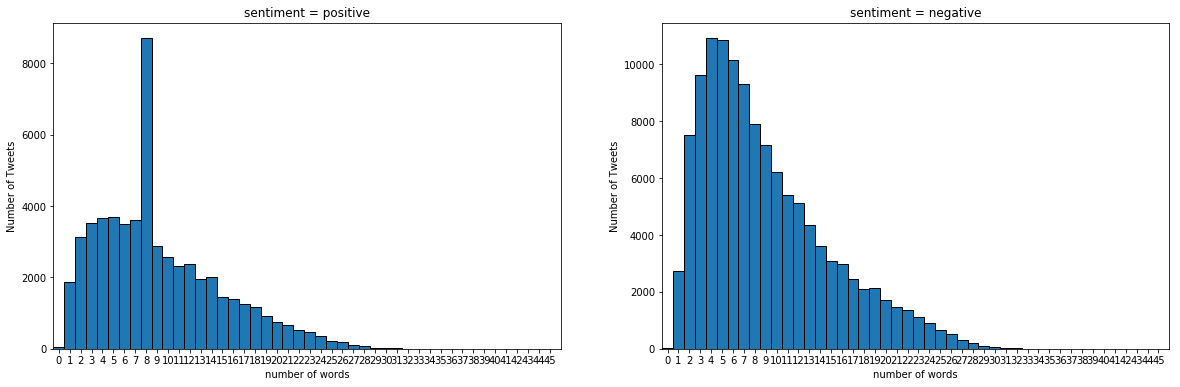

In [14]:
plot_hists(df_labeled_processed, 'number of words')

Looks like there are some tweets that don't contain any words, so let's go ahead and delete those.

In [15]:
# make list of empty tweets
empty_tweets = len(df_labeled_processed[df_labeled_processed['number of words'] == 0])

# convert empty tweets to NaN and drop from df
df_labeled_processed['tweet'].replace('', np.nan, inplace=True)
df_labeled_processed.dropna(subset=['tweet'], inplace=True)

print('Removed {} empty Tweets.'.format(empty_tweets))

Removed 59 empty Tweets.


Let's take a look at the outliers, tweets that contain the most and least words.

In [16]:
df_labeled_processed.sort_values(by=['number of words'], ascending=False).head()

,tweet,sentiment,number of words
24948,tini lt 3 lt 3 lt 3 lt 3 lt 3 lt 3 lt 3 lt 3 lt 3 lt 3 lt 3 lt 3 lt 3 lt 3 lt 3 lt 3 lt 3 lt 3 lt 3 lt 3 lt 3 lt 3 lt,positive,46
4876,no le voy a hablar no le voy a hablar no le voy a hablar no le voy a hablar no le voy a hablar no le voy a hablar no le voy a hablar hola,positive,36
49495,no le voy a hablar no le voy a hablar no le voy a hablar no le voy a hablar no le voy a hablar no le voy a hablar no le voy a hablar hola,positive,36
136224,me voy a dormir ya que van a dar las 5 y mañana me levantaré a las 2 y a ver si me voy a quedar sin comer como me ha pasado otras veces,negative,34
11780,un d a tendr el gusto de decir q eh visto la belleza de un leopardo eh tocado el pelaje de un tigre y eh o do el llanto de un le n,positive,33


In [17]:
df_labeled_processed[df_labeled_processed['number of words'] == 1].head(15)

,tweet,sentiment,number of words
38,buenas,positive,1
52,severo,positive,1
57,nochesitaaaaaa,positive,1
71,bieeeennn,positive,1
147,futbol,positive,1
219,buenas,positive,1
228,hoam,positive,1
264,marchando,positive,1
271,bina,positive,1
275,gracias,positive,1


Let's go ahead and just drop the longest tweet since it doesn't actually contain any real words and that way we can also make the xticks in the histogram easier to read. We'll hang on to the one word tweets, because they are still useful for determining sentiments. Also, it looks like there are some duplicate tweets, let's see how many.

In [18]:
# drop longest tweet with no real words
df_labeled_processed.drop([24948],axis=0,inplace=True)

In [19]:
duplicates = len(df_labeled_processed['tweet']) - len(set(df_labeled_processed['tweet']))
print('There are {} duplicate Tweets.'.format(duplicates))

There are 17156 duplicate Tweets.


Looks like there are quite a bit of duplicate tweets. We should remove them to eliminate noise when fitting the models, but first lets lemmatize the tweets, as this will likely produce more duplicates.

## Lemmatize Tweets

First we'll create a dictionary with all the lemmatization pairs which we'll use to replace words with their root form.

In [20]:
lemma_dict = {}
with open('../data/raw/lemmatization-es.txt', 'r', buffering=1000, encoding='utf-8-sig') as f:
#    head = [next(f) for x in range(10)]
    for line in f:
        key = line.split()[1]
        value = line.split()[0]
#        print(key , value)
        if key in lemma_dict:
            lemma_dict[key].append(value)
        else:
            lemma_dict[key] = [value]

### Fix common replacement mistakes using top 500 Spanish words

When lemmatizing the words we want to prevent replacing common words with verbs that have a conjugated tense with the same spelling. For example, the Spanish word 'como' is often used to mean 'like'/'as' in English but can also be the first person present tense of 'comer' which means to eat which a lot less common and a different meaning all together. To prevent Word2Vec to incorrectly learn the context of the most common words like this when are they are used we'll ignore these words when lemmatizing the text. First let's make a list of the most common words, and then we can make sure to select the right lemmatization pair, or ignore the word when lemmatizing the text. For this implementation we will only consider words that appear more than 500 times in our dataset of Tweets.

In [21]:
common_words = []
with open('../data/raw/500_most_common_words.txt', 'r') as f:
    for line in f:
        common_words.append(line.split()[1])

In [22]:
def count_occ(word):
    '''returns the number of times "word" appears in df_labeled_processed'''
    count = 0
    un_tweets = []
    for tweet in list(df_labeled_processed['tweet']):
        if ' ' + word + ' ' in tweet:
            count += 1
            un_tweets.append(tweet)
    return count

In [23]:
def find_replacements(list_of_words):
    ''' assert list of words unique, list_of_words must contain unique values'''
    words_dict = {}
    for word in tqdm(list_of_words):
        if word in lemma_dict:
            words_dict[word] = lemma_dict[word]
    return words_dict

In [24]:
# create a dictionary that has replacements 
common_words_dict = find_replacements(common_words)

In [25]:
common_verbs_dict = common_words_dict.copy()
for key in tqdm(common_words_dict):
    verbs = []
    for word in common_words_dict[key]:
        if word[-1:] == 'r':
            verbs.append(True)
        else:
            verbs.append(False)
    if True in verbs and count_occ(key) > 500 and len(common_words_dict[key]):
        pass
    else:
        common_verbs_dict.pop(key, None)

In [26]:
common_verbs_dict

{'es': ['ser'],
 'una': ['unir', 'uno'],
 'para': ['parar', 'parir'],
 'está': ['estar'],
 'como': ['comer'],
 'hay': ['haber'],
 'estoy': ['estar'],
 'tengo': ['tener'],
 'ha': ['haber'],
 'vamos': ['ir'],
 'soy': ['ser'],
 'puedo': ['poder'],
 'quiero': ['querer'],
 'tiene': ['tener'],
 'fue': ['ir', 'ser'],
 'son': ['ser'],
 'he': ['haber'],
 'era': ['erar', 'ser'],
 'eres': ['erar', 'ere', 'ser'],
 'así': ['asir'],
 'sé': ['saber', 'ser'],
 'tienes': ['tener'],
 'creo': ['crear', 'creer'],
 'puede': ['poder'],
 'voy': ['ir'],
 'nada': ['nadar'],
 'estaba': ['estar'],
 'están': ['estar'],
 'va': ['ir'],
 'sabes': ['saber'],
 'hace': ['hacer'],
 'puedes': ['poder'],
 'siento': ['sentar', 'sentir'],
 'uno': ['unir'],
 'quiere': ['querer'],
 'vas': ['ir'],
 'sea': ['ser'],
 'casa': ['casar'],
 'cosas': ['cosa', 'coser'],
 'necesito': ['necesitar'],
 'tienen': ['tener'],
 'dice': ['decir'],
 'gusta': ['gustar'],
 'pasa': ['pasar', 'paso'],
 'quería': ['querer'],
 'van': ['ir'],
 'veo': 

Examining the common_verbs_dict we create lists of words to ignore, or replace with the second or third entry respectively. Now let's go ahead and lemmatize the text.

In [27]:
labeled_tweets = [tweet.split() for tweet in list(df_labeled_processed['tweet'])]

ignored = ['nos', 'como', 'para', 'así', 'casa', 'uno']
select_second = ['una', 'era', 'eran', 'creo', 'seinto', 'haciendo']
select_third = ['eres']

for tweet in tqdm(labeled_tweets):
    for index, word in enumerate(tweet):
        if word in lemma_dict.keys():
            if word in ignored:
                continue
            elif word in select_second:
                tweet[index] = lemma_dict[word][1]
            elif word in select_third:
                tweet[index] = lemma_dict[word][2]
            else:
                tweet[index] = lemma_dict[word][0]
                    
lemmatized_tweets = [' '.join(tweet) for tweet in labeled_tweets]

Let's compare the tweets before and after the lemmatization.

In [28]:
df_labeled_processed['tweet'].head().tolist()

['se imaginan a los chicos agradeciendo por el premio con cara de orgullo que bonito one direction',
 'eclesiastes4 siempre promesa',
 'qué saborío pj ya no compartes ni un gintonic con nosotros',
 'buenos dias para todos feliz inicio de semana',
 'gracias no es así deja claro que es el 100 de aquí']

In [29]:
lemmatized_tweets[0:5]

['se imaginar a el chico agradecer por el premiar con caro de orgullo que bonito one direction',
 'eclesiastes4 siempre promesa',
 'qué saborío pj ya no comparte ni uno gintonic con nosotros',
 'bueno dias para todo feliz iniciar de semana',
 'gracia no ser así dejar claro que ser el 100 de aquí']

You can see how the verbs in the tweets got changed to their infinitive form, and pronouns are converted as well. Now let's update the dataframe with the lemmatized Tweets and remove duplicates.

In [30]:
# update 'tweets' series in df_labeled_processed with the lemmatized tweets
df_labeled_processed['tweet'] = lemmatized_tweets

In [31]:
# count duplicates
duplicates = len(df_labeled_processed['tweet']) - len(set(df_labeled_processed['tweet']))
print('There are {} duplicate Tweets.'.format(duplicates))

There are 18154 duplicate Tweets.


In [32]:
# remove duplicates
df_labeled_processed.drop_duplicates(subset=['tweet'], inplace=True)

In [33]:
# write to csv file for later analysis
df_labeled_processed.to_csv('../data/processed/labeled_tweets.csv', index=False)

Let's take another look now at the histograms of the lengths of tweets after preprocessing, and the statstics for each class.

Positive Tweets:
       number of words
count     45088.000000
mean          9.612935
std           5.872260
min           1.000000
25%           5.000000
50%           8.000000
75%          13.000000
max          36.000000
Negative Tweets
       number of words
count    114273.000000
mean          9.328932
std           5.763880
min           1.000000
25%           5.000000
50%           8.000000
75%          13.000000
max          34.000000


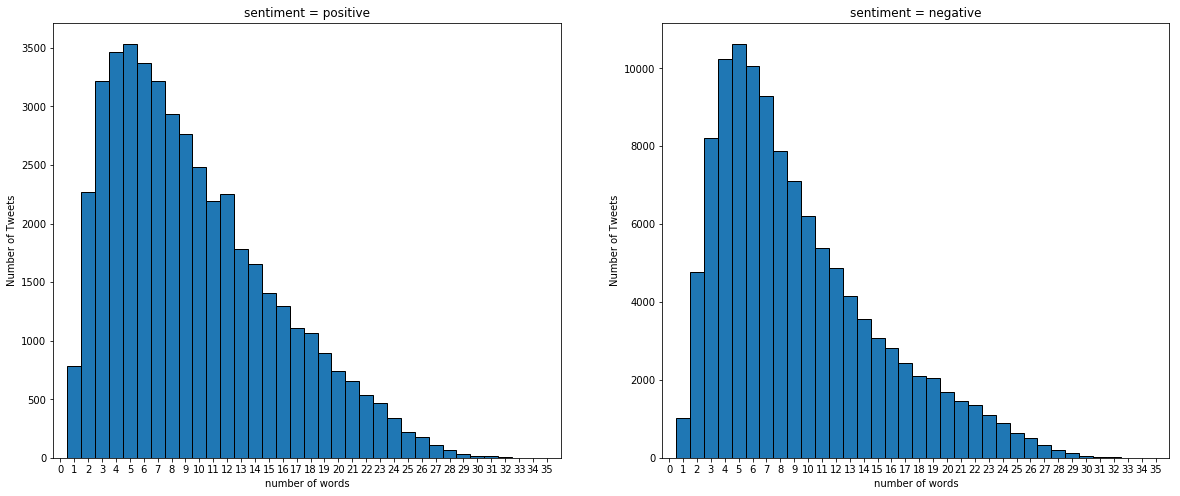

In [48]:
a = df_labeled_processed[df_labeled_processed['sentiment'] == 'positive'].describe()
b = df_labeled_processed[df_labeled_processed['sentiment'] == 'negative'].describe()
print('Positive Tweets:')
print(a)
print('Negative Tweets')
print(b)
plot_hists(df_labeled_processed, 'number of words')

Aside from the total count of Tweets, looks like distributions and stats are quite similar between classes. 

## Word2Vec tweets, unlabeled tweets and labeled tweets for training

Now let's create our dataset to train our Word2Vec model on. For this we will use all of the unlabeled Tweets, as well as the training set of labeled Tweets for our sentiment classifiers.

In [35]:
# creating train set for Word2Vec model
df_labeled_train, df_labeled_test = train_test_split(df_labeled_processed, test_size=0.2, random_state=7)

Let's take a look at the length of Tweets for the unlabeled Tweets and repeat the same preprocessing and lemmatization as before with the labeled Tweets.

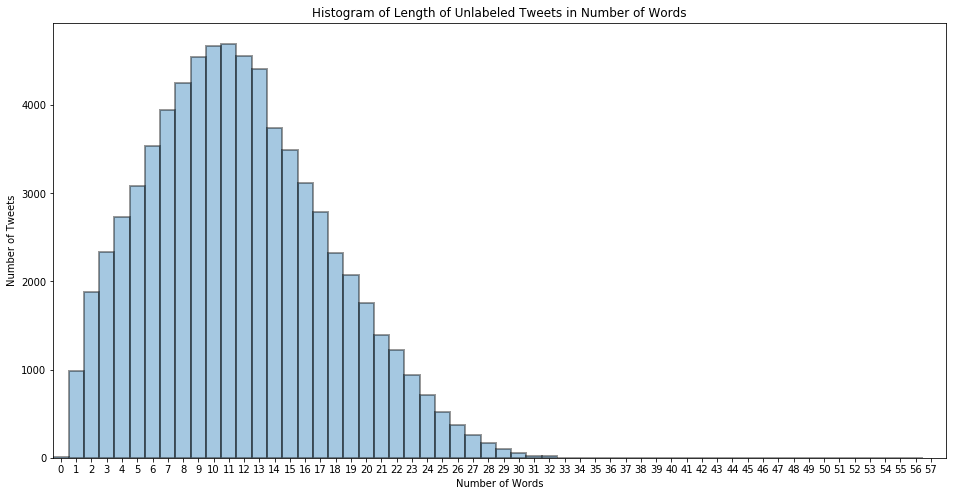

In [36]:
tweet_lengths = [len(tweet) for tweet in df_unlabeled_processed['tweet'].apply(lambda x: x.split())]
df_unlabeled_processed['number of words'] = tweet_lengths

bins = np.arange(0,max(tweet_lengths)) - 0.5
plt.figure(figsize=(16, 8))
sns.distplot(tweet_lengths, kde=False, bins=bins, hist_kws=dict(edgecolor="k", linewidth=2))
plt.xlim(left=-0.5,right=max(tweet_lengths))
plt.xticks(np.array(range(0,max(tweet_lengths))))
plt.xlabel('Number of Words')
plt.ylabel('Number of Tweets')
plt.title('Histogram of Length of Unlabeled Tweets in Number of Words')
plt.show()

In [37]:
# count and remove empty Tweets
empty_tweets = len(df_unlabeled_processed[df_unlabeled_processed['number of words'] == 0])
df_unlabeled_processed['tweet'].replace('', np.nan, inplace=True)
df_unlabeled_processed.dropna(subset=['tweet'], inplace=True)
print('Removed {} empty Tweets.'.format(empty_tweets))

Removed 10 empty Tweets.


In [38]:
# lemmatize Tweets
word2vec_tweets = [tweet.split() for tweet in list(df_unlabeled_processed['tweet'])]

ignored = ['nos', 'como', 'para', 'así', 'casa', 'uno']
select_second = ['una', 'era', 'eran', 'creo', 'seinto', 'haciendo']
select_third = ['eres']

for tweet in tqdm(word2vec_tweets[:10]):
    for index, word in enumerate(tweet):
        if word in lemma_dict.keys():
            if word in ignored:
                continue
            elif word in select_second:
                tweet[index] = lemma_dict[word][1]
            elif word in select_third:
                tweet[index] = lemma_dict[word][2]
            else:
                tweet[index] = lemma_dict[word][0]
                    
lemmatized_tweets = [' '.join(tweet) for tweet in word2vec_tweets]

In [39]:
# Tweets before lemmatization
df_unlabeled_processed['tweet'].head().tolist()

['quieres saber cómo hacer una aplicación para android wear te lo explicamos gt',
 'a veer que tal',
 'jajaja como les encanta trolear cuando alguno no se conecta jajaja',
 'mirando los simpson',
 'tu teléfono android permanecerá desbloqueado mientras lo lleves encima']

In [40]:
# Tweets after lemmatization
lemmatized_tweets[:5]

['querer saber cómo hacer uno aplicación para android wear te el explicar gt',
 'a veer que tal',
 'jajaja como les encantar trolear cuando alguno no se conectar jajaja',
 'mirar el simpson',
 'tu teléfono android permanecer desbloquear mientras el llevar encimar']

Now let's update the dataframe with the lemmatized Tweets and remove any duplicates.

In [41]:
# update Tweets in dataframe
df_unlabeled_processed['tweet'] = lemmatized_tweets

# count and drop duplicates
duplicates = len(df_unlabeled_processed['tweet']) - len(set(df_unlabeled_processed['tweet']))
df_unlabeled_processed.drop_duplicates(subset=['tweet'], inplace=True)

print('{} duplicate Tweets removed.'.format(duplicates))

6122 duplicate Tweets removed.


Unlabeled Tweets:
count    64602.000000
mean        11.864323
std          5.911076
min          1.000000
25%          7.000000
50%         11.000000
75%         16.000000
max         58.000000
Name: number of words, dtype: float64


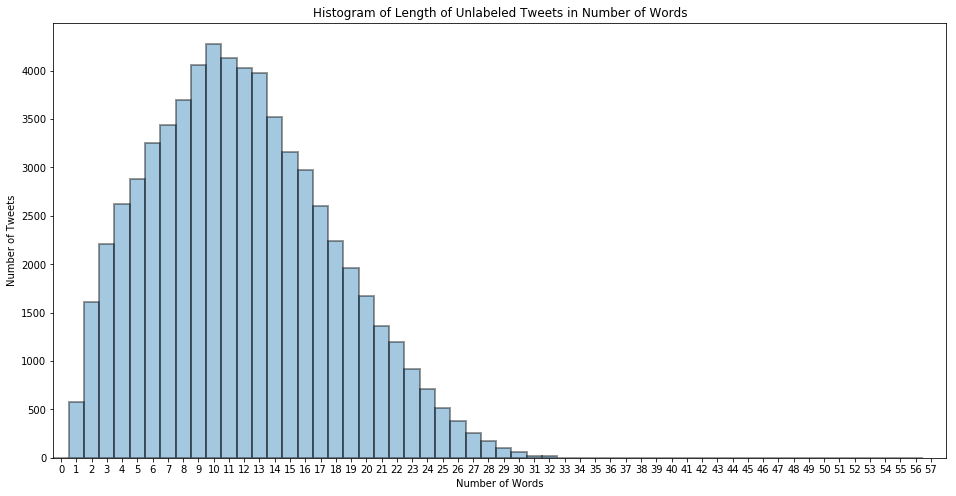

In [42]:
tweet_lengths = [len(tweet) for tweet in df_unlabeled_processed['tweet'].apply(lambda x: x.split())]
df_unlabeled_processed['number of words'] = tweet_lengths

print('Unlabeled Tweets:')
print(df_unlabeled_processed['number of words'].describe())
bins = np.arange(0,max(tweet_lengths)) - 0.5
plt.figure(figsize=(16, 8))
sns.distplot(tweet_lengths, kde=False, bins=bins, hist_kws=dict(edgecolor="k", linewidth=2))
plt.xlim(left=-0.5,right=max(tweet_lengths))
plt.xticks(np.array(range(0,max(tweet_lengths))))
plt.xlabel('Number of Words')
plt.ylabel('Number of Tweets')
plt.title('Histogram of Length of Unlabeled Tweets in Number of Words')
plt.show()

Interesting, looks like the unlabeled Tweets are a couple words longer on average than the labeled Tweets. Now we can concatenate the unlabeled Tweets with our training set of of labeled tweets to create the dataset we will use to train our Word2Vec model.

In [43]:
# create concatenated DF 
df_tweets = pd.concat([df_unlabeled_processed, df_labeled_train], axis=0, sort=True, ignore_index=True)

In [44]:
# write Tweets from concatenated DF to text file for training our Word2Vec model
with open('../data/processed/word2vec_tweets.txt', 'w') as f:
    for tweet in tqdm(df_tweets['tweet']):
        f.write(str(tweet) + '\n')

And that concludes our preprocessing of the data!